In [101]:
import os
import torch
import numpy as np
import nglview
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from tqdm import tqdm 
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from torch_geometric.data import Data, Batch 

import nglview
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from ase.visualize import view
from ase import Atoms
from xtb.ase.calculator import XTB


IPythonConsole.ipython_useSVG = True 
IPythonConsole.molSize = 300, 300
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets
from ipywidgets import interact, interactive, fixed, IntSlider

In [3]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [4]:
def repeat_data(data: Data, num_repeat) -> Batch:
    datas = [deepcopy(data) for i in range(num_repeat)]
    return Batch.from_data_list(datas)

def repeat_batch(batch: Batch, num_repeat) -> Batch:
    datas = batch.to_data_list()
    new_data = []
    for i in range(num_repeat):
        new_data += deepcopy(datas)
    return Batch.from_data_list(new_data)

In [5]:
from e3moldiffusion import chem
from geom.data import GeomDataModule, MolFeaturization
from geom.train_full import CoordsAtomScoreTrainer as Trainer
from geom.dataset_infos import get_dataset_info

In [6]:
def compute_distances(pos):
    d = torch.cdist(pos, pos)
    ids = torch.triu_indices(pos.size(0), pos.size(0), 1)
    d = torch.triu(d, diagonal=1)
    d = d[ids[0, :], ids[1, :]]
    return d

In [7]:
def compute_mmff_energy(mol):
    ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=0)
    ff.Initialize()
    out = ff.CalcEnergy()
    return out

In [8]:
!nvidia-smi

Fri Mar  3 05:35:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    42W / 300W |      0MiB / 32510MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!echo "checking if the compute node has access to the hpfs directory where data is stored."
!ls /hpfs/projects/mlcs

checking if the compute node has access to the hpfs directory where data is stored.
2022_deepfrag_collab  CrystalMD       methods_development  ProteinMassSpecPred
cct		      e3moldiffusion  pdm		   README-PROJECTS.txt
cct-working	      mdse	      potency_prediction   sms_workspace


In [10]:
device = "cuda:0"
# device = "cpu"

In [11]:
datapath = "/hpfs/projects/mlcs/e3moldiffusion/"
test_info_df = os.path.join(datapath, "qm9", "test_info.csv")
test_info_df = pd.read_csv(test_info_df)
smiles_to_mol_id = os.path.join(datapath, "qm9", "smiles_to_mol_id.csv")
smiles_to_mol_id = pd.read_csv(smiles_to_mol_id)
smiles_to_mol_id = {i:s for i, s in zip(smiles_to_mol_id.mol_id, smiles_to_mol_id.smiles)}
test_info_df["smiles"] = test_info_df["mol_id"].map(lambda x: smiles_to_mol_id.get(x))

In [76]:
# dataset = "qm9"
dataset = "drugs"

In [77]:
datamodule = GeomDataModule(
        batch_size=1,
        num_workers=1,
        dataset=dataset,
        env_in_init=True,
        shuffle_train=True,
        max_num_conformers=30
    )
datamodule.setup()

In [78]:
dinfo = "geom" if dataset == "drugs" else "qm9"
dataset_info = get_dataset_info(dataset_name=dinfo, remove_h=False)

In [79]:
max_num_nodes = dataset_info["max_n_nodes"]
n_nodes = dataset_info["n_nodes"]

In [80]:
print(max_num_nodes)
print()
print(n_nodes)

181

{3: 1, 4: 3, 5: 9, 6: 2, 7: 8, 8: 23, 9: 23, 10: 50, 11: 109, 12: 168, 13: 280, 14: 402, 15: 583, 16: 597, 17: 949, 18: 1284, 19: 1862, 20: 2674, 21: 3599, 22: 6109, 23: 8693, 24: 13604, 25: 17419, 26: 25672, 27: 31647, 28: 43809, 29: 56697, 30: 70400, 31: 82655, 32: 104100, 33: 122776, 34: 140834, 35: 164888, 36: 185451, 37: 194541, 38: 218549, 39: 231232, 40: 243300, 41: 253349, 42: 268341, 43: 272081, 44: 276917, 45: 276839, 46: 274747, 47: 272126, 48: 262709, 49: 250157, 50: 244781, 51: 228898, 52: 215338, 53: 203728, 54: 191697, 55: 180518, 56: 163843, 57: 152055, 58: 136536, 59: 120393, 60: 107292, 61: 94635, 62: 83179, 63: 68384, 64: 61517, 65: 48867, 66: 37685, 67: 32859, 68: 27367, 69: 20981, 70: 18699, 71: 14791, 72: 11921, 73: 9933, 74: 9037, 75: 6538, 76: 6374, 77: 4036, 78: 4189, 79: 3842, 80: 3277, 81: 2925, 82: 1843, 83: 2060, 84: 1394, 85: 1514, 86: 1357, 87: 1346, 88: 999, 89: 300, 90: 390, 91: 510, 92: 510, 93: 240, 94: 721, 95: 360, 96: 360, 97: 390, 98: 330, 99

In [81]:
empirical_distribution_num_nodes = {i: n_nodes.get(i) for i in range(max_num_nodes)}
empirical_distribution_num_nodes_tensor = {}
for key, value in empirical_distribution_num_nodes.items():
    if value is None:
        value = 0
    empirical_distribution_num_nodes_tensor[key] = value
print(empirical_distribution_num_nodes_tensor)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 3, 5: 9, 6: 2, 7: 8, 8: 23, 9: 23, 10: 50, 11: 109, 12: 168, 13: 280, 14: 402, 15: 583, 16: 597, 17: 949, 18: 1284, 19: 1862, 20: 2674, 21: 3599, 22: 6109, 23: 8693, 24: 13604, 25: 17419, 26: 25672, 27: 31647, 28: 43809, 29: 56697, 30: 70400, 31: 82655, 32: 104100, 33: 122776, 34: 140834, 35: 164888, 36: 185451, 37: 194541, 38: 218549, 39: 231232, 40: 243300, 41: 253349, 42: 268341, 43: 272081, 44: 276917, 45: 276839, 46: 274747, 47: 272126, 48: 262709, 49: 250157, 50: 244781, 51: 228898, 52: 215338, 53: 203728, 54: 191697, 55: 180518, 56: 163843, 57: 152055, 58: 136536, 59: 120393, 60: 107292, 61: 94635, 62: 83179, 63: 68384, 64: 61517, 65: 48867, 66: 37685, 67: 32859, 68: 27367, 69: 20981, 70: 18699, 71: 14791, 72: 11921, 73: 9933, 74: 9037, 75: 6538, 76: 6374, 77: 4036, 78: 4189, 79: 3842, 80: 3277, 81: 2925, 82: 1843, 83: 2060, 84: 1394, 85: 1514, 86: 1357, 87: 1346, 88: 999, 89: 300, 90: 390, 91: 510, 92: 510, 93: 240, 94: 721, 95: 360, 96: 360, 97: 390

In [82]:
empirical_distribution_num_nodes_tensor = torch.tensor(list(empirical_distribution_num_nodes_tensor.values())).float()

In [83]:
empirical_distribution_num_nodes_tensor

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 9.0000e+00,
        2.0000e+00, 8.0000e+00, 2.3000e+01, 2.3000e+01, 5.0000e+01, 1.0900e+02,
        1.6800e+02, 2.8000e+02, 4.0200e+02, 5.8300e+02, 5.9700e+02, 9.4900e+02,
        1.2840e+03, 1.8620e+03, 2.6740e+03, 3.5990e+03, 6.1090e+03, 8.6930e+03,
        1.3604e+04, 1.7419e+04, 2.5672e+04, 3.1647e+04, 4.3809e+04, 5.6697e+04,
        7.0400e+04, 8.2655e+04, 1.0410e+05, 1.2278e+05, 1.4083e+05, 1.6489e+05,
        1.8545e+05, 1.9454e+05, 2.1855e+05, 2.3123e+05, 2.4330e+05, 2.5335e+05,
        2.6834e+05, 2.7208e+05, 2.7692e+05, 2.7684e+05, 2.7475e+05, 2.7213e+05,
        2.6271e+05, 2.5016e+05, 2.4478e+05, 2.2890e+05, 2.1534e+05, 2.0373e+05,
        1.9170e+05, 1.8052e+05, 1.6384e+05, 1.5206e+05, 1.3654e+05, 1.2039e+05,
        1.0729e+05, 9.4635e+04, 8.3179e+04, 6.8384e+04, 6.1517e+04, 4.8867e+04,
        3.7685e+04, 3.2859e+04, 2.7367e+04, 2.0981e+04, 1.8699e+04, 1.4791e+04,
        1.1921e+04, 9.9330e+03, 9.0370e+

In [84]:
dataset_info["atom_encoder"]

{'H': 0,
 'B': 1,
 'C': 2,
 'N': 3,
 'O': 4,
 'F': 5,
 'Al': 6,
 'Si': 7,
 'P': 8,
 'S': 9,
 'Cl': 10,
 'As': 11,
 'Br': 12,
 'I': 13,
 'Hg': 14,
 'Bi': 15}

In [85]:
integer_to_el = {val: key for key, val in dataset_info["atom_encoder"].items()}

In [86]:
integer_to_el

{0: 'H',
 1: 'B',
 2: 'C',
 3: 'N',
 4: 'O',
 5: 'F',
 6: 'Al',
 7: 'Si',
 8: 'P',
 9: 'S',
 10: 'Cl',
 11: 'As',
 12: 'Br',
 13: 'I',
 14: 'Hg',
 15: 'Bi'}

In [87]:
get_atomic_number = lambda x: Chem.GetPeriodicTable().GetAtomicNumber(integer_to_el.get(x))

In [88]:
print(f"Training set. Number of structures: {len(datamodule.train_dataset)}")
print(f"Validation set. Number of structures: {len(datamodule.val_dataset)}")
print(f"Test set. Number of structures: {len(datamodule.test_dataset)}")

Training set. Number of structures: 6512131
Validation set. Number of structures: 641189
Test set. Number of structures: 103753


In [89]:
loader = iter(datamodule.val_dataloader(shuffle=True))

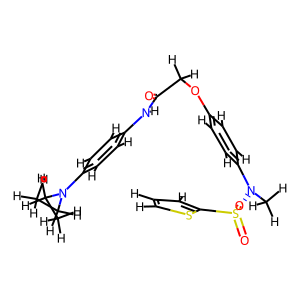

In [90]:
data = next(loader).to(device)
mol = data.mol[0]
mol

In [91]:
data.xgeom

tensor([2, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 4, 2, 0, 0, 4, 2, 2, 2,
        2, 2, 2, 0, 0, 3, 9, 4, 4, 2, 2, 2, 2, 9, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [92]:
run = 0

In [93]:
model = Trainer.load_from_checkpoint(f'logs/{dataset}/run{str(run)}/last.ckpt', strict=False).to(device)
model = model.eval()

In [94]:
sum(m.numel() for m in model.parameters() if m.requires_grad)

875312

In [95]:
model.hparams.fully_connected

False

In [96]:
num_graphs = 32

In [97]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, xohes, xohes_integer, batch_num_nodes, trajs = model.reverse_sampling(num_graphs=num_graphs,
                                                                               empirical_distribution_num_nodes=empirical_distribution_num_nodes_tensor,
                                                                               verbose=True,
                                                                               save_traj=True)

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.04it/s]


In [98]:
pos = pos.split(batch_num_nodes.cpu().tolist(), dim=0)
xohes_integer = xohes_integer.split(batch_num_nodes.cpu().tolist(), dim=0)

In [107]:
i = 2

pos_np = pos[i].detach().cpu().numpy()
numbers = xohes_integer[i].detach().cpu().numpy()
numbers = np.array([get_atomic_number(a) for a in numbers])

atoms = Atoms(positions=pos_np, numbers=numbers)
view(atoms, viewer='x3d')

In [108]:
atoms.calc = XTB(method="GFN2-xTB")
pot_e = atoms.get_potential_energy()

In [109]:
pot_e

-2307.41535576063